In [1]:
# read a CAMELS basin from the shapefile and convert it to SCRIP netcdf format

import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [2]:
# read a CAMELS basin
file = '/glade/p/ral/hap/common_data/camels/shapefile/HCDN_nhru_final_671.buff_fix_holes.gpkg'
shp = gpd.read_file(file)
shp

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,geometry
0,1013500,0.0,-68.56551,47.01169,2.303988e+09,277.493490,None,None,647993,"MULTIPOLYGON (((-68.47770 47.17825, -68.47758 ..."
1,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,None,None,312624,"MULTIPOLYGON (((-67.97836 44.61310, -67.97873 ..."
2,1030500,0.0,-68.14985,45.80527,3.676155e+09,174.433896,None,None,662248,"MULTIPOLYGON (((-68.35800 45.67903, -68.35838 ..."
3,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,None,None,309614,"MULTIPOLYGON (((-69.67647 45.14558, -69.67636 ..."
4,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,None,None,310157,"MULTIPOLYGON (((-70.10847 45.21669, -70.10858 ..."
...,...,...,...,...,...,...,...,...,...,...
666,14309500,0.0,-123.74216,42.83017,2.263143e+08,737.623894,None,None,117484,"MULTIPOLYGON (((-123.81322 42.89103, -123.8131..."
667,14316700,0.0,-122.64677,43.45290,5.880250e+08,947.553082,None,None,176861,"MULTIPOLYGON (((-122.49936 43.47688, -122.4990..."
668,14325000,0.0,-124.02763,42.79249,4.449257e+08,649.241611,None,None,166110,"MULTIPOLYGON (((-124.07751 42.89822, -124.0771..."
669,14362250,0.0,-123.12535,42.16583,4.387790e+07,939.577778,None,None,44972,"MULTIPOLYGON (((-123.15128 42.19624, -123.1511..."


In [3]:
# select one basin and convert its largest geometry to points
target = 80
shpi = shp.loc[[target]]

polygon = shpi.iloc[0]['geometry']

if polygon.geom_type == 'Polygon':
    max_area = polygon.area
    largest_polygon = polygon
elif polygon.geom_type == 'MultiPolygon':
    max_area = -1
    for part in polygon.geoms:
        area = part.area
        if area > max_area:
            largest_polygon = part
            max_area = area
            
coords = np.array((largest_polygon.exterior.coords))
print(coords.shape)

(3286, 2)


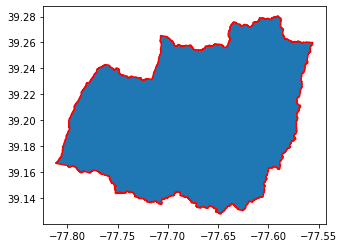

In [4]:
fig, ax = plt.subplots()
shpi.plot(ax=ax)
ax.plot(coords[:,0], coords[:,1], 'r')

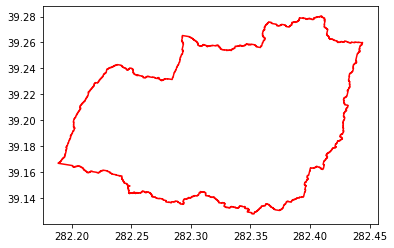

In [5]:
coords[:,0] = 360 + coords[:,0]
plt.plot(coords[:,0], coords[:,1], 'r')

In [6]:
def sort_xy(x, y):

    x0 = np.mean(x)
    y0 = np.mean(y)

    r = np.sqrt((x-x0)**2 + (y-y0)**2)

    angles = np.where((y-y0) > 0, np.arccos((x-x0)/r), 2*np.pi-np.arccos((x-x0)/r))

    mask = np.argsort(angles)

    x_sorted = x[mask]
    y_sorted = y[mask]

    return x_sorted, y_sorted

coords2 = coords[::100,:]
print(coords2.shape)
lon_corner, lat_corner = sort_xy(coords2[:,0], coords2[:,1])

(33, 2)


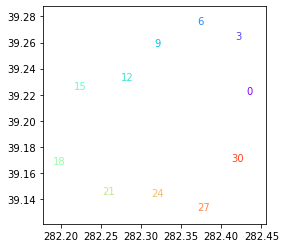

In [7]:

import matplotlib.cm as cm

num_colors = len(lon_corner)
cmap = cm.get_cmap('rainbow')  # sequential colormap from light to dark red

colors = [cmap(i/num_colors) for i in range(num_colors)]

fig, ax = plt.subplots(figsize=[4,4])
for i in range(len(lon_corner)):
    ax.plot(lon_corner[i], lat_corner[i], '.', color='w')
    if np.mod(i, 3) == 0:
        ax.text(lon_corner[i], lat_corner[i], i, color=colors[i])

In [8]:
# convert to SCRIP unstructured grid
# https://earthsystemmodeling.org/docs/release/ESMF_8_0_1/ESMF_refdoc/node3.html#SECTION03028100000000000000
# Here is a sample header from a SCRIP unstructured grid file:

# netcdf ne4np4-pentagons {
# dimensions:
#       grid_size = 866 ;
#       grid_corners = 5 ;
#       grid_rank = 1 ;
# variables:
#       int grid_dims(grid_rank) ;
#       double grid_center_lat(grid_size) ;
#          grid_center_lat:units = "degrees" ;
#       double grid_center_lon(grid_size) ;
#          grid_center_lon:units = "degrees" ;
#       double grid_corner_lon(grid_size, grid_corners) ;
#          grid_corner_lon:units = "degrees";
#          grid_corner_lon:_FillValue = -9999. ;
#       double grid_corner_lat(grid_size, grid_corners) ;
#          grid_corner_lat:units = "degrees" ;
#          grid_corner_lat:_FillValue = -9999. ;
#       int grid_imask(grid_size) ;
#          grid_imask:_FillValue = -9999. ;
#       double grid_area(grid_size) ;
#          grid_area:units = "radians^2" ;
#          grid_area:long_name = "area weights" ;
# }
# The variables are the same as described above, however, here grid_rank = 1. In this format there is no notion of which cells are next to which, so to construct the unstructured mesh the connection between cells is defined by searching for cells with the same corner coordinates. (e.g. the same grid_corner_lat and grid_corner_lon values).


lat_cen = [np.nanmean(lon_corner)]
lon_cen = [np.nanmean(lat_corner)]
grid_imask = np.array([1], dtype=np.int64)
grid_area = [max_area]

lat_corner = lat_corner[np.newaxis, :]
lon_corner = lon_corner[np.newaxis, :]

ds = xr.Dataset()
# grid_rank = 1
# grid_size = 2
# grid_corners = 5

ds['grid_dims'] = xr.DataArray(np.array([1], dtype=np.int64), dims=('grid_rank'))

ds['grid_center_lat'] = xr.DataArray(lat_cen, dims=('grid_size'))
ds['grid_center_lat'].attrs['units'] = "degrees"

ds['grid_center_lon'] = xr.DataArray(lon_cen, dims=('grid_size'))
ds['grid_center_lon'].attrs['units'] = "degrees"

ds['grid_corner_lat'] = xr.DataArray(lat_corner, dims=('grid_size', 'grid_corners'))
ds['grid_corner_lat'].attrs['units'] = "degrees"
ds['grid_corner_lat'].attrs['_FillValue'] = -9999.

ds['grid_corner_lon'] = xr.DataArray(lon_corner, dims=('grid_size', 'grid_corners'))
ds['grid_corner_lon'].attrs['units'] = "degrees"
ds['grid_corner_lon'].attrs['_FillValue'] = -9999.

ds['grid_imask'] = xr.DataArray(grid_imask, dims=('grid_size'))
ds['grid_imask'].attrs['_FillValue'] = -9999.

ds['grid_area'] = xr.DataArray(grid_area, dims=('grid_size'))
ds['grid_area'].attrs['units'] = "radians^2"
ds['grid_area'].attrs['long_name'] = "area weights"

ds.to_netcdf(f'CAMELS_{target}.nc', format='NETCDF3_CLASSIC')

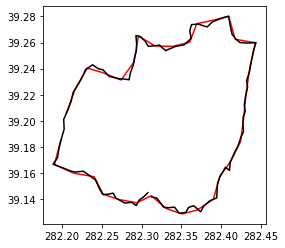

In [12]:
# a comparison to Sean's grids
# CAMELS 80 VS Sean's 10

file1 = '/glade/u/home/guoqiang/test_mesh/basin/CAMELS_80_ESMFmesh.nc'
file2 = '/glade/u/home/guoqiang/CTSM_cases/CAMELS_Calib/Lump_basin_divide_split_nest/ESMFmesh_ctsm_HCDN_nhru_final_671.buff_fix_holes_polygons_simplified_5e-4_split_nested_basin10.nc'
ds1 = xr.load_dataset(file1)
ds2 = xr.load_dataset(file2)

coord1 = ds1.nodeCoords
coord2 = ds2.nodeCoords

fig, ax = plt.subplots(figsize=[4,4])

ax.plot(coord1[:,0], coord1[:,1], 'r')
ax.plot(coord2[:,0], coord2[:,1], 'k')